# Word2Vec - The Skip-Gram Model

word2vec is a method of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks.

Word2Vec is one of many different word embedding techniques. In turn, word embedding is one of the most popular representation of document vocabulary. Thus, we get the following hierarchy:

Document vocabulary representation -> Word embedding -> Word2Vec
Word embedding is a vector representation of a word.

Word2Vec is a more sophisticated word embedding technique. This technique is based on the idea that words that occur in the same contexts tend to have similar meanings.

Word2Vec is a two-layer neural network that takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space (Wikipedia).

Below we provide a known graphic representations of Word2Vec's word embedding. This picture gives an intuition about how word embedding looks like in Word2Vec.

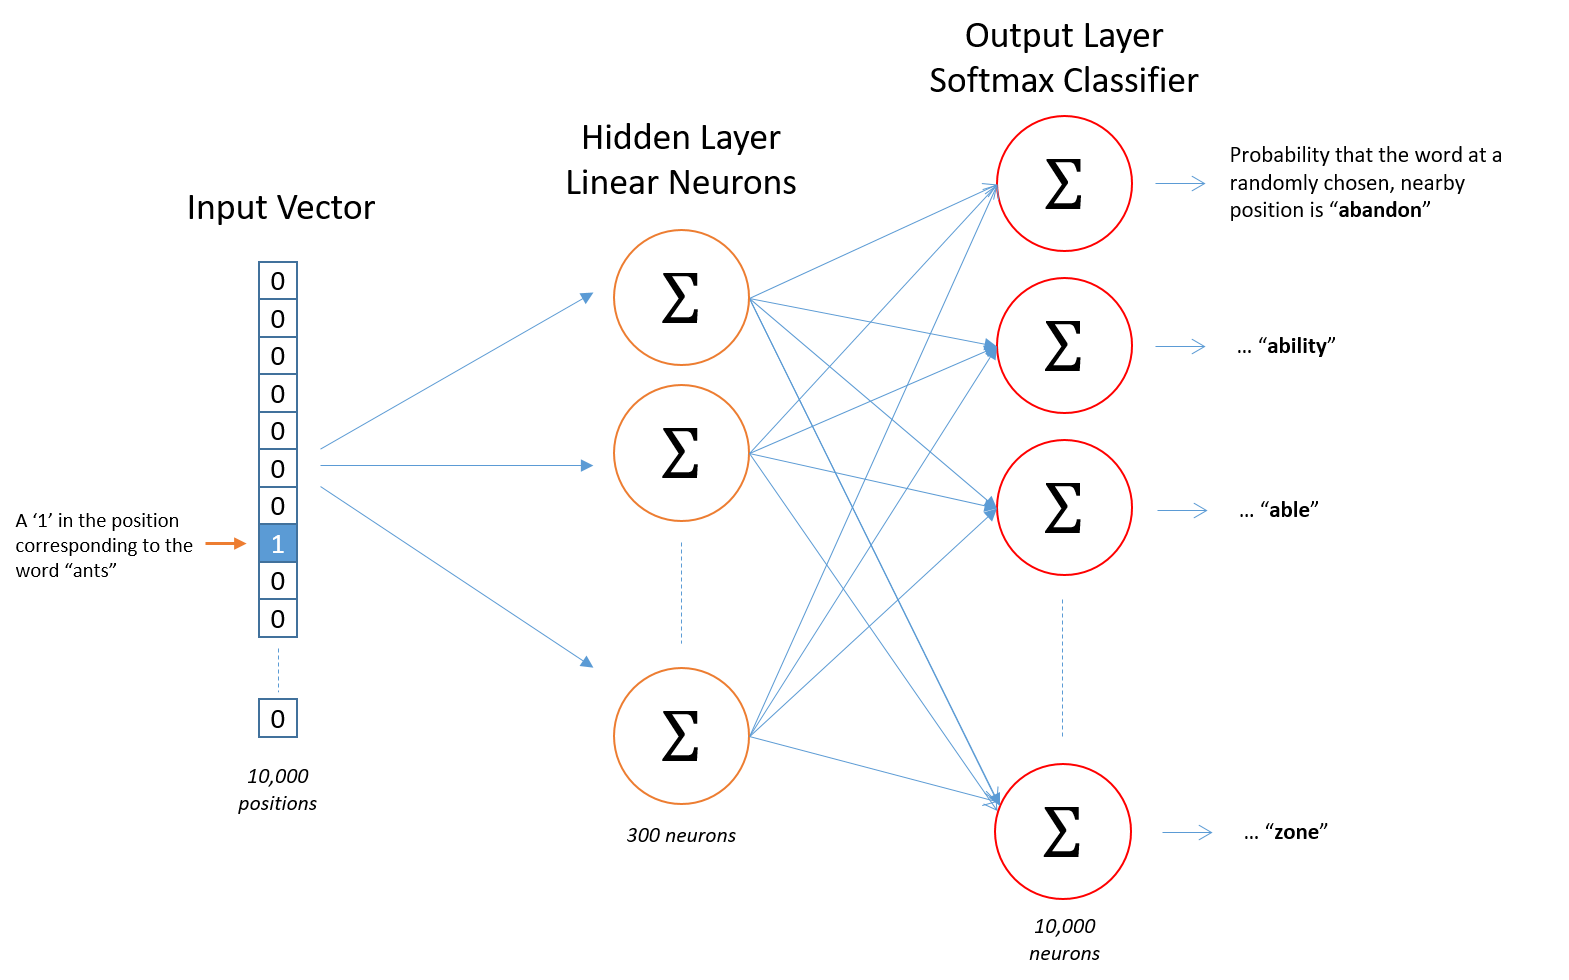

For those who wants to jump right to the find most similar function tab:

[Find most similar function](#Most_Similar)

# Imports

In [25]:
from string import punctuation
import nltk 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io

import tensorflow as tf
from keras.layers import *
from tensorflow.keras import layers
from tensorflow import keras
from keras.preprocessing import text
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import TextVectorization

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Downloading neccesery resources for cleaning the data

In [26]:
# Download punkt model and stopwords from nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Idan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Idan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparing the data

In [27]:
# import text file 
corpus = []
with open("reviews_data.txt",'r', encoding="utf8") as data_file:
    for line in data_file:
        corpuslines = line.split()
        corpus.append(corpuslines)

cutted_corpus = corpus[:50]
print(cutted_corpus)

[['oct', 'nice', 'trendy', 'hotel', 'location', 'not', 'too', 'bad', 'stayed', 'in', 'this', 'hotel', 'for', 'one', 'night', 'as', 'this', 'is', 'fairly', 'new', 'place', 'some', 'of', 'the', 'taxi', 'drivers', 'did', 'not', 'know', 'where', 'it', 'was', 'and', 'or', 'did', 'not', 'want', 'to', 'drive', 'there', 'once', 'have', 'eventually', 'arrived', 'at', 'the', 'hotel', 'was', 'very', 'pleasantly', 'surprised', 'with', 'the', 'decor', 'of', 'the', 'lobby', 'ground', 'floor', 'area', 'it', 'was', 'very', 'stylish', 'and', 'modern', 'found', 'the', 'reception', 'staff', 'geeting', 'me', 'with', 'aloha', 'bit', 'out', 'of', 'place', 'but', 'guess', 'they', 'are', 'briefed', 'to', 'say', 'that', 'to', 'keep', 'up', 'the', 'coroporate', 'image', 'as', 'have', 'starwood', 'preferred', 'guest', 'member', 'was', 'given', 'small', 'gift', 'upon', 'check', 'in', 'it', 'was', 'only', 'couple', 'of', 'fridge', 'magnets', 'in', 'gift', 'box', 'but', 'nevertheless', 'nice', 'gesture', 'my', 'roo

In [28]:
# Clean and normalize the text
# We create a function for text preprocessing that removes extra whitespaces, digits, and stopwords and lower casing the text corpus, that return the normelized document. 
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document) 

In [29]:
# Extract unique word from the corpus and assigning a numeric identifier.
norm_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in cutted_corpus]
norm_corpus = [' '.join(tok_sent) for tok_sent in norm_corpus]
norm_corpus = filter(None, normalize_corpus(norm_corpus)) 
norm_corpus = [tok_sent for tok_sent in norm_corpus if len(tok_sent.split()) > 2]
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:5])

Vocabulary Size: 1704
Vocabulary Sample: [('hotel', 1), ('room', 2), ('beijing', 3), ('good', 4), ('taxi', 5)]


Tensorflow functional API provides model skip-gram, which generate a sequence of word index into tuples of words of the form:</br>
(word, word in the same window), with label 1 (positive samples).</br>
(word, random word from the vocabulary), with label 0 (negative samples)

* In any case that a word match itself, Ofcourse, the result will plot 1.

In [30]:
# generate skip-grams
skip_grams = [tf.keras.preprocessing.sequence.skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(20):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        id2word[pairs[i][0]], pairs[i][0], 
        id2word[pairs[i][1]], pairs[i][1], 
        labels[i])) 


(stay (7), would (13)) -> 1
(bottles (801), nice (21)) -> 1
(stayed (15), night (135)) -> 1
(coffee (799), get (18)) -> 1
(shopping (197), occitaine (938)) -> 0
(away (159), mar (1138)) -> 0
(facilities (190), bank (626)) -> 0
(sites (520), work (251)) -> 0
(hotel (1), mao (185)) -> 0
(gym (62), pool (44)) -> 1
(pleasantly (512), want (80)) -> 1
(aloha (788), travel (138)) -> 0
(lobby (188), ground (379)) -> 1
(would (13), lost (1627)) -> 0
(ground (379), arrived (137)) -> 1
(hotel (1), area (35)) -> 1
(drivers (42), safe (334)) -> 0
(couple (157), regular (724)) -> 0
(drive (785), channel (1096)) -> 0
(selection (382), living (132)) -> 0


Next, we provide individual target and context words, so the input size for each input variable is (1,). Then, we create an embedding layer, which creates by the vocabolary size and the embed limit(vectors size) we set. – Embedding().

In [31]:
# create some input variables with the functional API
embed_size = 128
input_target = Input((1,))
input_context = Input((1,))
embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')

In [32]:
# create our input 
target = embedding(input_target)
target = Reshape((embed_size, 1))(target)
context = embedding(input_context)
context = Reshape((embed_size, 1))(context)

In [33]:
# setup a cosine similarity operation, this is the cosine similarity between the two word vectors, target, and context.
similarity = dot([target, context], axes=1, normalize=True)

In [34]:
# now perform the dot product operation to get a similarity measure
dot_product = dot([target, context], axes=1, normalize=True)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

In [35]:
# create the training model
model = Model([input_target, input_context], output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       218112      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 reshape_3 (Reshape)            (None, 128, 1)       0           ['embedding[0][0]']        

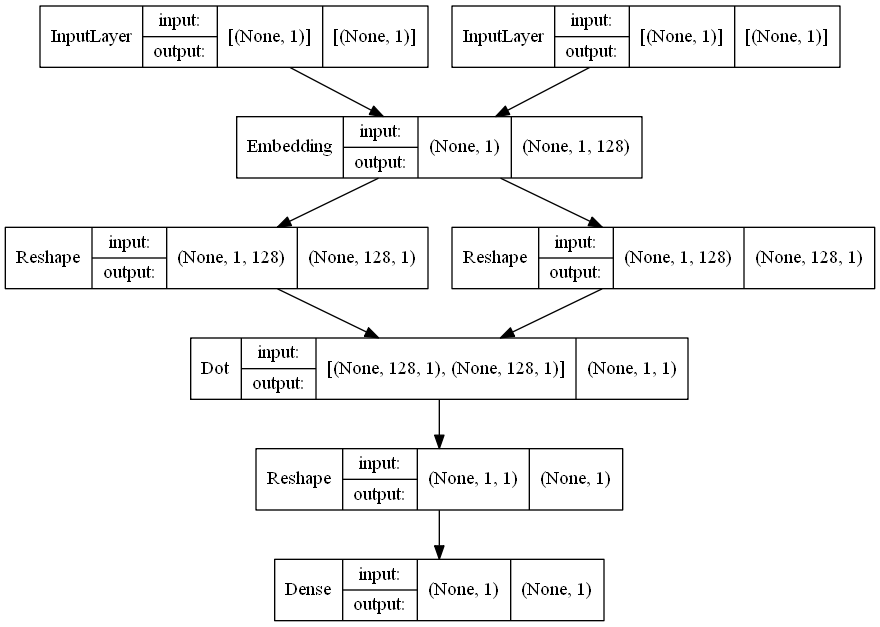

In [37]:
# visualize model structure
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='TB')

Training the model on our complete corpus takes alot of time, </br>
so, we are running a model for ten epochs.

loss functions tell us how much the predicted output of the model differs from the actual output- It can be seen that the loss is relatively small relative to the amount of data:

In [38]:
for epoch in range(1, 5):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
             print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y) 
    print('Epoch:', epoch, 'Loss:', loss) 

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 12.198829263448715
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 11.758081540465355
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 11.343243405222893
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 10.999675512313843


Here we extract the weights of embeddings from our model embedding layer-to get word embeddings for our entire vocabulary.</br>
With the cos sin similarty we calculate the similarty between two words.</br>
Then use it to implement a function that collect the 10 highest score of similarities, That mean that the 10 words with the highest score are most similar to the word received as input in the function.

In [39]:
weights = model.get_layer('embedding').get_weights()[0]
vectors = []
words = []

for index, word in enumerate(word2id):
    vec = weights[index]
    vectors.append([x for x in vec])
    words.append(word)

dataframe = pd.DataFrame(
    {'Word': words,
     'Vector': vectors
    })
dataframe.index += 1 
dataframe.to_parquet('data.parquet')

# Find most similar function <a class="anchor" id="Most_Similar"></a>

In [40]:
word_vec_data = pd.read_parquet('data.parquet') # parquet path

vectors = word_vec_data[['Vector']]
vectors = np.array(vectors.Vector.tolist())

word_column = word_vec_data[['Word']]
word_column['index1'] = word_column.index
word_dic = word_column.set_index('Word').to_dict()['index1']

def cos_sin_sim (word1 , word2):
    weight1 = vectors[word_dic[word1]]
    weight2 = vectors[word_dic[word2]]
    result = np.dot(weight1, weight2)/(np.linalg.norm(weight1)*np.linalg.norm(weight2))
    return result

inv_word_dic = {v: k for k, v in word_dic.items()}

def find_most_similar(word ,k = 10):
    wordslist = []
    dict_words =  {}
    cos_similarty =  [None] * len(inv_word_dic)
    for i in range(1,len(inv_word_dic)):
        x = cos_sin_sim(word,inv_word_dic[i])
        dict_words[x] = i
        cos_similarty[i] = x
    cos_similarty = cos_similarty[1:]
    cos_similarty = np.sort(cos_similarty,kind = 'heapsort')
    for i in range(-2,-k-2,-1):
        print("The word: " + inv_word_dic[dict_words[cos_similarty[i]]] + ", cosine similarity score : " + str(cos_similarty[i]) + "\n")
        wordslist.append(inv_word_dic[dict_words[cos_similarty[i]]])
    return wordslist

Here we show a plot of the 10 most similar words and their score odf similarty.

In [41]:
Results = find_most_similar('hotel')

The word: beijing, cosine similarity score : 0.92674285

The word: good, cosine similarity score : 0.9056432

The word: stayed, cosine similarity score : 0.9011034

The word: would, cosine similarity score : 0.8753224

The word: rooms, cosine similarity score : 0.86806256

The word: location, cosine similarity score : 0.86098194

The word: stay, cosine similarity score : 0.8590062

The word: room, cosine similarity score : 0.8523947

The word: taxi, cosine similarity score : 0.8516672

The word: ascott, cosine similarity score : 0.8516143



# Dimensionality reduction

Here we use a 2d projection, dimensionality reduction.

In [42]:
pca = PCA(n_components=2)
two_d_pca = pca.fit_transform(weights)
print(two_d_pca)

[[ 0.05919559  0.04970002]
 [ 0.42295465  0.04336651]
 [ 0.3840967  -0.10700835]
 ...
 [-0.01051619  0.01743958]
 [-0.0701412  -0.04342928]
 [-0.06037203 -0.02974683]]


We are choosing interesting words by thier close meaning and then try to plot them and see if they are really close according to our model. The chosen words are: hotel, room, place and stay.

In [43]:
# Creating the dictionary for the unique words

chosen_word_dict = {}
unique_word_dict = {}

# Append to dictionary for the chosen words
for word, i in word2id.items():
    if word == 'hotel':
        chosen_word_dict.update({word: i})
    elif word == 'room':
        chosen_word_dict.update({word: i})
    elif word == 'place':
        chosen_word_dict.update({word: i})
    elif word == 'stay':
        chosen_word_dict.update({word: i})

chosen_words = list(chosen_word_dict.keys())
embedding_dict = {}
for word in chosen_words: 
    embedding_dict.update({
        word: two_d_pca[chosen_word_dict.get(word)]
        })        

# Append to dictionary for all words
for i, word in enumerate(word2id):
        unique_word_dict.update({word: i})

words = list(unique_word_dict.keys())
embedding_dict2 = {}
for word in words: 
    embedding_dict2.update({
        word: two_d_pca[unique_word_dict.get(word)]
        })

Text(0.5, 1.0, '2 Component PCA')

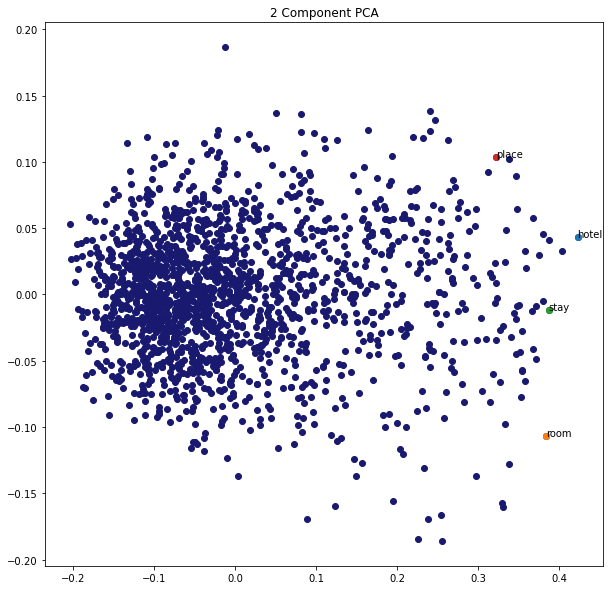

In [44]:
plt.figure(figsize=(10, 10))
    
for word in list(unique_word_dict.keys()):
    coord = embedding_dict2.get(word)
    plt.scatter(coord[0], coord[1], c='midnightblue')
    
for word in list(chosen_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    
plt.title('2 Component PCA')

We can see how close the words are in our data by the plot above. it's validating that the model is pretty good.

In [45]:
pca_dataset = pd.DataFrame(data = two_d_pca, columns = ['PC1', 'PC2'])

C:\Users\Idan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[Text(0.5, 0, 'Number of clusters, k'), Text(0, 0.5, 'Inertia')]

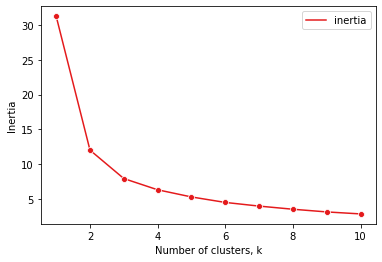

In [46]:
# finding the right number of clusters
inertia = []
for k in range(1,11):
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(two_d_pca) 
    inertia.append(model.inertia_) 
inertia = pd.DataFrame({"inertia":inertia}, index=range(1,11))
ax = sns.lineplot(data=inertia, marker= "o" ,palette='Set1')
ax.set(xlabel='Number of clusters, k', ylabel='Inertia')

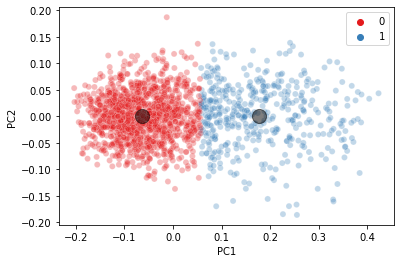

In [47]:
# plotting the clusters: K-mean
model = KMeans(n_clusters=2, random_state=42)
model.fit(pca_dataset)
labels = model.predict(pca_dataset)
sns.scatterplot(x = pca_dataset['PC1'], y = pca_dataset['PC2'],alpha=0.3, hue=labels, palette='Set1')
ax.set(xlabel='PC1', ylabel='PC2')
centers = model.cluster_centers_ 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200,alpha=0.5) # Plot centroids on top of clusters

From the Kmeans results we can clearly see the two clusters, and as we saw at the plot, few sections before, our chosen words relates to the blue cluster. What makes sense, as they have close meaning.

# Conclusions

We have extracted an Airbnb reviews data, It's kind of a large data, so we have cut it to 50 lines only, from the reason that our computers have limited resources. Then, we have prepared the data for our skip gram model, which been chosen to be the functional API way. We used tokenizing methods, got rid of punctuation, numbers. Then, indexed and vectorized every single word.
After that, we generated the skip gram model and looked for negative or positive pairs.
Then, we were ready to build the architecture for our model according to the functional API method.
Next, we have trained our model and caulculated the cosine similarity between each word, what gave us the opportunity to build a function that can find most similar word by thier cosine similarity score.
The results was pretty good, and loss was very low, So, we was ready to move on. 
Immediately after, we implemented the PCA method, to make our data more simple and ready for research.
We have found that a chosen words by meaning are plot that with our model. then we moved on to look for how many clusters we have.

As we end with this project, we have learned alot of things.
First, computer can get "translations" from not numeric data into a vectors and get set-up by special neural networks to get many properties extracted.
Tesnorflow and Keras are large libraries that contain huge amount of methods for treating neural networks projects.
From extracting data to analyzing tools.

We have got the opportunity to get our hands on the PCA method that is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Plus, we have got the opportunity to implement Kmeans algorithm and check how many clusters we have got, and how they looks like.
